In [1]:
import random
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None


##### Load Data

In [2]:
df = pd.read_excel('../data_processed/women_activists.xlsx')

##### Drop Null, Empty, and NaN values

In [3]:
df.dropna(subset=['text'], inplace=True) #remove nan value
df.drop_duplicates(subset=['text'], inplace=True) #remove nan duplicate value
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=1, how='all').loc[:, df.notna().any()]

##### Clean Data

In [4]:
def clean_tweet_text(text):
    # Check for null or NaN values
    if pd.isnull(text):
        return text
    # Remove URL
    text = re.sub(r'http\S+', '', text)
    
    # Remove RT (retweet) tag
    text = text.replace('RT', '')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters and punctuations, and add a space after removing them
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hashtags
    text = re.sub(r'#(\w+)', '', str(text))
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text
# Apply the cleaning function to 'text' column
df['text'] = df['text'].apply(clean_tweet_text)


In [5]:
# df = pd.read_excel('../data_processed/women_activists.xlsx')

##### Remove Text Less then 30 characters

In [6]:
df = df[df['text'].str.len() >=30]

##### Remove Empty Rows

In [7]:
def remove_empty_rows(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove rows with empty values in the column
        df = df[df[column].notna() & df[column].astype(str).str.strip().ne('')]
    return df

df = remove_empty_rows(df)


##### Remove All Null Values

In [8]:
def remove_null_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column contains any null values
        if df[column].isnull().any():
            # If any null value exists, drop the column
            df = df.drop(column, axis=1)
    return df
df = remove_null_columns(df)


##### Remove Stopwords

In [9]:
from nltk.corpus import stopwords
def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df
df = remove_stopwords(df)

##### Convert Timezone

In [10]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

##### Drop the whole rows which is >=2020

In [11]:
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
filtered_df = df[df["created_at"].dt.year >= 2020]
df.drop(df[df["created_at"].dt.year <= 2020].index, inplace=True)


##### Check How Many accounts are there

In [12]:
len(df['name'].unique())

51

##### Labeling Process

In [13]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str)

In [14]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment Analysis

In [15]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

##### Data Set Summary

In [16]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)

Sentiment Counts:
 sentiment
neutral     13582
positive    13531
negative     7724
Name: count, dtype: int64
Total Counts: 21255


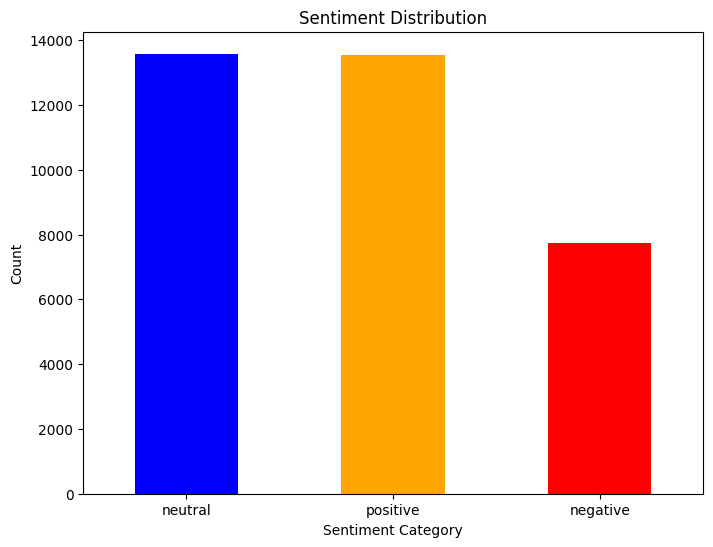

Sentiment Distribution: 21255


In [17]:
# Define custom colors for sentiment categories
colors = {'negative': 'red', 'neutral': 'blue', 'positive': 'orange'}

# Calculate sentiment counts
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment counts with custom colors
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=[colors.get(x, 'gray') for x in sentiment_counts.index])
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Sentiment Distribution')
plt.show()

# Calculate total counts
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Sentiment Distribution:", total_counts)


##### Calculate positive tweets and percentage for women, single user

In [18]:
women_positive_count = df[(df['gender'] == 'female') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'female'].shape[0]
women_positive_percentage = (women_positive_count / women_total_count) * 100
# Print the results
print("Positive tweets from women:", women_positive_count, "(", women_positive_percentage, "%)")

Positive tweets from women: 13531 ( 38.840887562074805 %)


##### Content Analysis

In [19]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  13615


In [20]:
df.shape

(34837, 8)

##### Code Schema

In [21]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

In [22]:
df_edu[['text','sentiment','sentiment_score','gender','label','codes']].sample(5)

,text,sentiment,sentiment_score,gender,label,codes
6286,confirmed several women traveled afghanistan either work taliban projects advertise afghanistan full flowers flowers,positive,0.250,female,1,[women]
249,need justify existence parents need justify need go school,neutral,0.000,female,1,[school]
7860,qari saeed khosti yearold girl medical university elaha forcibly married sent hospital beatings htt,positive,0.125,female,1,"[women, university]"
17954,speakupforafghan women international womenday internationalwomenday,neutral,0.000,female,1,[women]
17596,speakupforafghan women taliban trying silence isolate afghan women international community deal one crisis excuses,neutral,0.000,female,1,[women]


##### Visualization

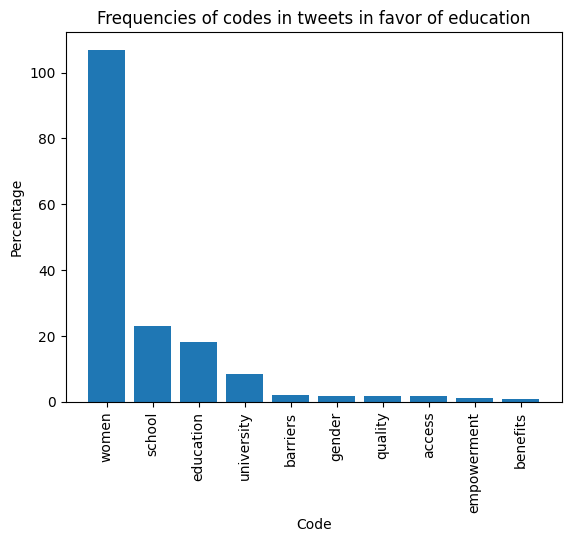

In [23]:
df_codes = df_edu.explode('codes')
# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100
# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
sentiment
negative    1677
neutral     3593
positive    3457
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'education':
sentiment
negative     448
neutral      690
positive    1074
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
negative    636
neutral     976
positive    829
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative    198
neutral     442
positive    368
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
negative    1147
neutral     1953
positive    1824
Name: text, dtype: int64


##### Sentiment for each keywords with its percentage

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets['sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    # Calculate the sentiment distribution for the keyword
    sentiment_distribution = keyword_tweets.groupby('sentiment')['text'].count()
    total_tweets = sentiment_distribution.sum()
    
    # Calculate the percentage of each sentiment category
    sentiment_percentage = sentiment_distribution / total_tweets * 100
    
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    for sentiment, count in sentiment_distribution.items():
        percentage = sentiment_percentage[sentiment]
        if sentiment == 'positive':
            sentiment_label = 'Positive'
        elif sentiment == 'negative':
            sentiment_label = 'Negative'
        else:
            sentiment_label = 'Neutral'
        print(f"{sentiment_label}: {count} ({percentage:.2f}%)")


Sentiment analysis of tweets containing the keyword 'women':
Negative: 1677 (19.22%)
Neutral: 3593 (41.17%)
Positive: 3457 (39.61%)
Sentiment analysis of tweets containing the keyword 'education':
Negative: 448 (20.25%)
Neutral: 690 (31.19%)
Positive: 1074 (48.55%)
Sentiment analysis of tweets containing the keyword 'school':
Negative: 636 (26.05%)
Neutral: 976 (39.98%)
Positive: 829 (33.96%)
Sentiment analysis of tweets containing the keyword 'university':
Negative: 198 (19.64%)
Neutral: 442 (43.85%)
Positive: 368 (36.51%)
Sentiment analysis of tweets containing the keyword 'girl':
Negative: 1147 (23.29%)
Neutral: 1953 (39.66%)
Positive: 1824 (37.04%)


In [26]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())

Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    13
neutral     44
positive    38
Name: text, dtype: int64


In [27]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative    13 (13.7%)
neutral     44 (46.3%)
positive    38 (40.0%)
Name: text, dtype: object


##### Average sentiment

In [28]:
import random
from textblob import TextBlob
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for all tweets: {mean_sentiment}")


Average sentiment score for all tweets: 0.06257727652464494


##### Sentiment Category

In [29]:
import numpy as np
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)                     0.067405
(education, access)              0.095076
(education, access, benefits)   -0.600000
(education, access, gender)      0.000000
(education, barriers)            0.000000
Name: text, dtype: float64

##### Calculate the sentiment scores for all tweets

In [30]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
# Compare the sentiment distributions using a t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment For whole tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment For whole tweets:
T-statistic: 42.01121298491029
P-value: 0.0


In [31]:
import scipy.stats as stats
from textblob import TextBlob

keywords = ['women', 'education', 'school', 'university', 'girl']

# Filter tweets containing the keywords
men_education_tweets = df[df['text'].str.contains('|'.join(keywords), case=False)]

# Calculate sentiment scores using TextBlob
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]

# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)

# Print the comparison results
print("Comparison of Sentiment for Women Education Tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment for Women Education Tweets:
T-statistic: 28.321068608930144
P-value: 1.6955424742616196e-171


In [32]:
import scipy.stats as stats
from textblob import TextBlob

keywords = ['women education']

# Filter tweets containing the keywords
men_education_tweets = df[df['text'].str.contains('|'.join(keywords), case=False)]

# Calculate sentiment scores using TextBlob
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]

# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)

# Print the comparison results
print("Comparison of Sentiment for Women Education Keyword:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment for Women Education Keyword:
T-statistic: 3.432135926285973
P-value: 0.0008918697804590749


#### Calculate the sentiment scores for tweets containing each keyword

In [33]:
keyword_sentiment = {}
for keyword in keywords:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)]
    sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in keyword_tweets['text']]
    keyword_sentiment[keyword] = np.mean(sentiment_scores)
print("Sentiment Scores by Keyword:")
for keyword, sentiment_score in keyword_sentiment.items():
    print(f"{keyword}: {sentiment_score}")


Sentiment Scores by Keyword:
women education: 0.06257727652464494


##### Chi-square test of independence

In [34]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['gender'], df['label'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square Test of Independence:
Chi-square: 0.0
P-value: 1.0


##### Create a cross-tabulation between sentiment and gender

In [35]:
cross_tab = pd.crosstab(df['sentiment'], df['gender'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
gender     female
sentiment        
negative     7724
neutral     13582
positive    13531


In [36]:
cross_tab = pd.crosstab(df['gender'], df['label'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
label       0      1
gender              
female  21222  13615


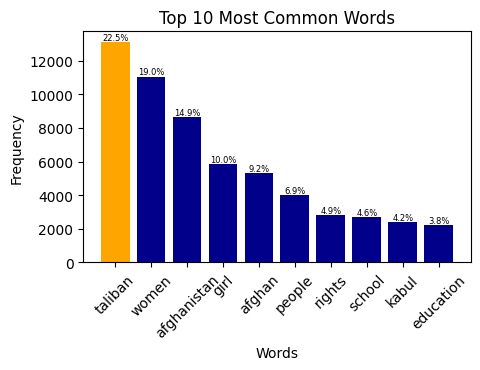

In [44]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Calculate the total frequency of all words
total_frequency = sum(frequencies)

# Calculate the percentages
percentages = [count / total_frequency * 100 for count in frequencies]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar chart for the most common words
bars = ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=6)

# Show the chart
plt.show()


In [38]:
for word, count in most_common_words:
    print(f'{word}: {count}')

taliban: 13079
women: 11054
afghanistan: 8665
girl: 5830
afghan: 5339
people: 4002
rights: 2843
school: 2694
kabul: 2417
education: 2239


##### Calculate descriptive statistics for women


In [39]:
women_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'female']['text']]
# Calculate descriptive statistics for women
women_mean_sentiment = np.mean(women_sentiment_scores)
women_median_sentiment = np.median(women_sentiment_scores)
women_std_sentiment = np.std(women_sentiment_scores)
women_quartiles_sentiment = np.percentile(women_sentiment_scores, [25, 50, 75])
print("Descriptive Statistics for Women:")
print("Mean Sentiment:", women_mean_sentiment)
print("Median Sentiment:", women_median_sentiment)
print("Standard Deviation of Sentiment:", women_std_sentiment)
print("Quartiles of Sentiment:", women_quartiles_sentiment)


Descriptive Statistics for Women:
Mean Sentiment: 0.05817350455305021
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.25844857843392527
Quartiles of Sentiment: [0.   0.   0.15]


##### Time Series

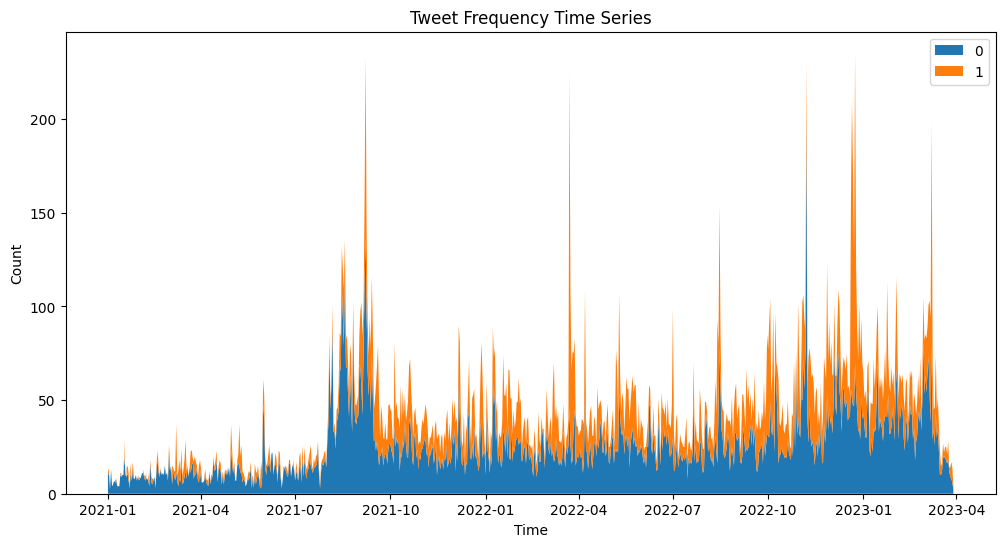

In [40]:

sentiment_counts = df.groupby(['created_at', 'label']).size().unstack()
# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(sentiment_counts.index)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the stacked area plot for sentiment categories
ax.stackplot(time_periods, sentiment_counts.T, labels=sentiment_counts.columns)
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')
# Add legend
ax.legend()
# Show the chart
plt.show()

##### Freqency Tweet

In [41]:
# Group the data by user name and count the number of tweets
user_tweet_counts = df.groupby('name').size().reset_index(name='tweet_count')

# Sort the user_tweet_counts DataFrame by tweet_count in descending order
user_tweet_counts = user_tweet_counts.sort_values(by='tweet_count', ascending=False)

# Print the top 10 users with the highest tweet counts
print(user_tweet_counts.head(10))


                name  tweet_count
9   Farahnaz Forotan         2612
30     Samira Hamidi         2520
22     NasimiShabnam         2298
42            maryam         2036
34      SodabaBayani         1629
11      Fawzia Koofi         1576
2      Anisa.Shaheed         1423
23   NigoraFazliddin         1398
17       Mariamistan         1378
6      BBCYaldaHakim         1180


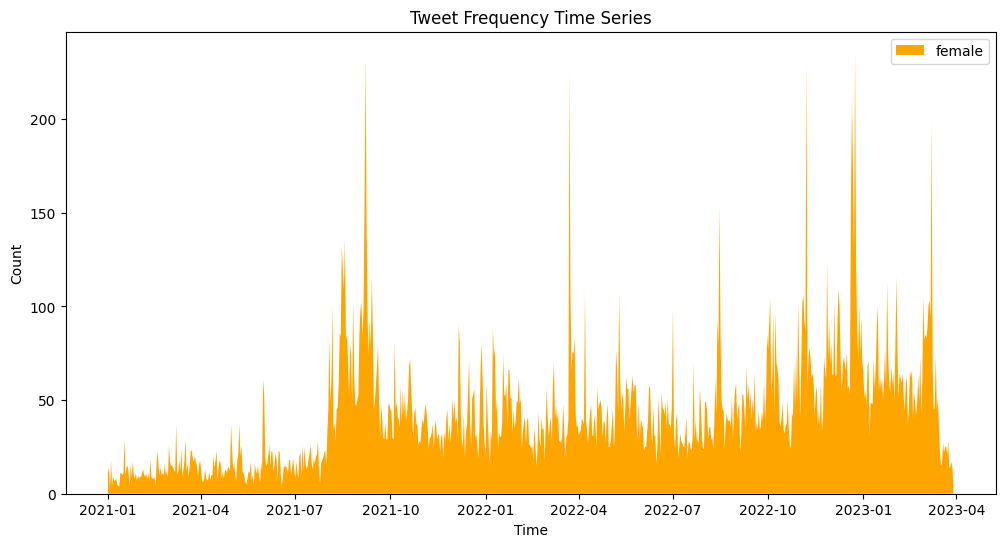

In [42]:
# Group the data by 'created_at' and 'gender', and count the number of tweets for each gender
freq_counts = df.groupby(['created_at', 'gender']).size().unstack()

# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(freq_counts.index)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the stacked area plot for genders
ax.stackplot(time_periods, freq_counts.T, labels=freq_counts.columns, colors=['orange', 'darkblue'])

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')

# Add legend
ax.legend()

# Show the chart
plt.show()


In [43]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
# Create a WordCloud object with customized options
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
# Add a central word
wordcloud.generate_from_text("Afghanistan")
# Manipulate font sizes for the central word and other words
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
wordcloud.words_["Afghanistan"] = 80  # Set font size for the central word
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
df.shape

(34837, 8)

In [ ]:
df[['text']].sample(10)

,text
20069,forced migration panjshir stop tajik genocide forced migration andrab stop tajik genocide
19393,never seen someone stupid cowardly ignorant person always opens mouth full stench without meaning without meaning wish much zeal owl accompanied jackals turkey
24042,daudjunbish kubra noorzai afghanistans health minister half century ago
5440,ban taliban top trend afghanistan tweets growing
14744,world mistake afghan women bravery change taliban afghan women always stood oppression history thats theyre taliban changed r must show action dont fool ppl fancy words
27434,tajikgirl_ expensive handmade embroidery
13911,die without stopping cause another generation die path yes battle beautiful like womans cry
18639,two months update girl grade allowed go school taliban killing time misleading direction giving fake assurance allowed young girl traumatized born post taliban era dont even know fault
33739,khabarnagar means silent language afghanistan one proud media country national house journalists thank
29247,afghanistan mean time ban taliban travels unless reopen school afghan girl stop afghan women work also representative afghan women call great government australia speed visa process


In [ ]:
df.to_excel('../data_processed/women_activists.xlsx', index=False)